# **Kaggle HW5: Olivia Fang**

# Begin with imports

In [601]:
import requests

def save_file(url, file_name):
    r = requests.get(url)
    with open(file_name, 'wb') as f:
      f.write(r.content)

save_file('https://courses.cs.washington.edu/courses/cse416/23sp/homeworks/hw5/edx_train.csv',
          'edx_train.csv')
save_file('https://courses.cs.washington.edu/courses/cse416/23sp/homeworks/hw5/edx_test.csv',
          'edx_test.csv')

In [602]:
from sklearn.metrics import confusion_matrix,classification_report,roc_auc_score,precision_recall_curve,roc_curve,make_scorer
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier

In [603]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam

In [604]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

Define our targeted predicting column to be 'certified'.

Since the user ID is unique for every user, it won't help with prediction, therefore, it is dropped.

In [605]:
target = "certified"
df_train = pd.read_csv('edx_train.csv').drop(['userid_DI'], axis=1)

In [606]:
df_train['LoE_DI'].value_counts()

LoE_DI
Bachelor's             2954
Master's               2325
Secondary              1989
Doctorate               315
Less than Secondary     209
Name: count, dtype: int64

# Check Training Data

In [607]:
# look at the data
df_train

,course_id,registered,viewed,explored,certified,final_cc_cname_DI,LoE_DI,YoB,gender,start_time_DI,last_event_DI,nevents,ndays_act,nplay_video,nchapters,nforum_posts
0,HarvardX/CS50x/2012,1,1,1,1,United States,Master's,1984.0,m,3/10/13,7/29/13,1161.0,50.0,NaN,12.0,0
1,HarvardX/ER22x/2013_Spring,1,1,1,1,United Kingdom,Master's,1985.0,f,3/13/13,8/1/13,1360.0,10.0,NaN,29.0,0
2,HarvardX/CS50x/2012,1,1,1,1,India,NaN,NaN,NaN,8/2/12,7/25/13,77.0,18.0,NaN,7.0,0
3,HarvardX/ER22x/2013_Spring,1,1,1,1,United Kingdom,Bachelor's,1982.0,m,1/23/13,8/13/13,1425.0,29.0,NaN,34.0,0
4,HarvardX/CS50x/2012,1,1,0,0,United States,Secondary,1989.0,m,3/5/13,3/5/13,6.0,1.0,NaN,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8753,HarvardX/CS50x/2012,1,0,0,0,Unknown/Other,Bachelor's,1992.0,m,11/10/12,NaN,NaN,NaN,NaN,NaN,0
8754,HarvardX/PH207x/2012_Fall,1,1,1,1,India,Master's,1972.0,f,10/1/12,1/16/13,1962.0,16.0,112.0,13.0,0
8755,HarvardX/CS50x/2012,1,0,0,0,Unknown/Other,Doctorate,1973.0,m,9/21/12,NaN,NaN,NaN,NaN,NaN,0
8756,HarvardX/ER22x/2013_Spring,1,1,1,1,United States,Master's,1981.0,m,6/18/13,8/19/13,1110.0,23.0,NaN,32.0,2


We can already see there are missing values, so let's get an exact count of the missing values.

In [608]:
np.sum(df_train.isna())

course_id               0
registered              0
viewed                  0
explored                0
certified               0
final_cc_cname_DI       0
LoE_DI                966
YoB                   914
gender                775
start_time_DI           0
last_event_DI        1508
nevents              1639
ndays_act            1639
nplay_video          6747
nchapters            2563
nforum_posts            0
dtype: int64

After reading about the column details, I found that missing values in 'nevents', 'ndays_act', 'nplay_video', 'nchapters', just indicate the user has never performed the action. So I will use 0 to replace missing values in those columns.

Missing value in 'last_event_DI' means that the user has never interacted with the platform since the date of registration. Hence if a user has NaN in 'last_event_DI', they should also have NaN value in columns such as 'ndays_act'.

We can check if that is true:

In [609]:
# check if there are rows with non-na value in 'ndays_act' but na in 'last_event_DI'
df_train[(df_train['last_event_DI'].isna()) & (df_train['ndays_act'].notna())]

,course_id,registered,viewed,explored,certified,final_cc_cname_DI,LoE_DI,YoB,gender,start_time_DI,last_event_DI,nevents,ndays_act,nplay_video,nchapters,nforum_posts


As expected, there are no such columns.

# Data Cleaning

### Initial

In [610]:
columns_to_update = ['ndays_act', 'nplay_video', 'nchapters', 'nevents']
df_train[columns_to_update] = df_train[columns_to_update].fillna(0)

In [611]:
# check
df_train

,course_id,registered,viewed,explored,certified,final_cc_cname_DI,LoE_DI,YoB,gender,start_time_DI,last_event_DI,nevents,ndays_act,nplay_video,nchapters,nforum_posts
0,HarvardX/CS50x/2012,1,1,1,1,United States,Master's,1984.0,m,3/10/13,7/29/13,1161.0,50.0,0.0,12.0,0
1,HarvardX/ER22x/2013_Spring,1,1,1,1,United Kingdom,Master's,1985.0,f,3/13/13,8/1/13,1360.0,10.0,0.0,29.0,0
2,HarvardX/CS50x/2012,1,1,1,1,India,NaN,NaN,NaN,8/2/12,7/25/13,77.0,18.0,0.0,7.0,0
3,HarvardX/ER22x/2013_Spring,1,1,1,1,United Kingdom,Bachelor's,1982.0,m,1/23/13,8/13/13,1425.0,29.0,0.0,34.0,0
4,HarvardX/CS50x/2012,1,1,0,0,United States,Secondary,1989.0,m,3/5/13,3/5/13,6.0,1.0,0.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8753,HarvardX/CS50x/2012,1,0,0,0,Unknown/Other,Bachelor's,1992.0,m,11/10/12,NaN,0.0,0.0,0.0,0.0,0
8754,HarvardX/PH207x/2012_Fall,1,1,1,1,India,Master's,1972.0,f,10/1/12,1/16/13,1962.0,16.0,112.0,13.0,0
8755,HarvardX/CS50x/2012,1,0,0,0,Unknown/Other,Doctorate,1973.0,m,9/21/12,NaN,0.0,0.0,0.0,0.0,0
8756,HarvardX/ER22x/2013_Spring,1,1,1,1,United States,Master's,1981.0,m,6/18/13,8/19/13,1110.0,23.0,0.0,32.0,2


We also need to convert all non-numerical variables to numerical values. After reading the documentation for 'start_time_DI' and 'last_event_DI', I decided to combine them into the count of days the user was registered. And if 'last_event_DI' is NaN, it means the user never interacted with the platform, so the duration should be 0.

In [612]:
# Convert the columns to datetime
df_train['start_time_DI'] = pd.to_datetime(df_train['start_time_DI'], format='%m/%d/%y')
df_train['last_event_DI'] = pd.to_datetime(df_train['last_event_DI'], format='%m/%d/%y', errors='coerce')

# Calculate the duration in days, replacing NaN with 0
df_train['duration_days'] = (df_train['last_event_DI'] - df_train['start_time_DI']).dt.days
df_train['duration_days'].fillna(0, inplace=True)
df_train['duration_days'] = df_train['duration_days'].astype(int)

For the remaining columns containing missing values, I decided to use models to predict those missing values.

So first I need to use one-hot encoding to encode the categorical variables with no missing values.

In [613]:
encoder = OneHotEncoder(sparse=False)
encoded_features = encoder.fit_transform(df_train[['final_cc_cname_DI', 'course_id']])
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out())

# Combine with original data
df_train = pd.concat([df_train, encoded_df], axis=1)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [614]:
# check
df_train

,course_id,registered,viewed,explored,certified,final_cc_cname_DI,LoE_DI,YoB,gender,start_time_DI,...,final_cc_cname_DI_Spain,final_cc_cname_DI_Ukraine,final_cc_cname_DI_United Kingdom,final_cc_cname_DI_United States,final_cc_cname_DI_Unknown/Other,course_id_HarvardX/CB22x/2013_Spring,course_id_HarvardX/CS50x/2012,course_id_HarvardX/ER22x/2013_Spring,course_id_HarvardX/PH207x/2012_Fall,course_id_HarvardX/PH278x/2013_Spring
0,HarvardX/CS50x/2012,1,1,1,1,United States,Master's,1984.0,m,2013-03-10,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,HarvardX/ER22x/2013_Spring,1,1,1,1,United Kingdom,Master's,1985.0,f,2013-03-13,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,HarvardX/CS50x/2012,1,1,1,1,India,NaN,NaN,NaN,2012-08-02,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,HarvardX/ER22x/2013_Spring,1,1,1,1,United Kingdom,Bachelor's,1982.0,m,2013-01-23,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,HarvardX/CS50x/2012,1,1,0,0,United States,Secondary,1989.0,m,2013-03-05,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8753,HarvardX/CS50x/2012,1,0,0,0,Unknown/Other,Bachelor's,1992.0,m,2012-11-10,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
8754,HarvardX/PH207x/2012_Fall,1,1,1,1,India,Master's,1972.0,f,2012-10-01,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
8755,HarvardX/CS50x/2012,1,0,0,0,Unknown/Other,Doctorate,1973.0,m,2012-09-21,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
8756,HarvardX/ER22x/2013_Spring,1,1,1,1,United States,Master's,1981.0,m,2013-06-18,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [615]:
# create a new df with the categorical columns dropped
df_num = df_train.drop(['final_cc_cname_DI', 'start_time_DI', 'last_event_DI', 'course_id'], axis=1)

### Second part - predict missing values

In [616]:
# define a method for confusion matrix
def metrics_score(actual, predicted):
    print(classification_report(actual, predicted))

    cm = confusion_matrix(actual, predicted)
    plt.figure(figsize=(8,5))

    sns.heatmap(cm, annot=True,  fmt='.2f')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

In [617]:
# first column to predict
column1 = 'LoE_DI'

In [618]:
# get the df of rows with no na values as training data
df_clean = df_num.dropna()

In [619]:
# the rows with missing values in the column of interest acts as the testing set
df_loe = df_num[df_num[column1].isna()]

In [620]:
# since the test data might have missing values in 'YoB', 'gender', we will drop them here
X_train_loe = df_clean.drop(['LoE_DI', 'YoB', 'gender'], axis=1)
y_train_loe = df_clean[column1]

In [621]:
model_loe = RandomForestClassifier(random_state=42)
model_loe.fit(X_train_loe, y_train_loe)

RandomForestClassifier(random_state=42)

                     precision    recall  f1-score   support

         Bachelor's       0.80      0.97      0.87      2929
          Doctorate       0.98      0.80      0.88       313
Less than Secondary       0.98      0.76      0.85       209
           Master's       0.96      0.87      0.91      2289
          Secondary       0.93      0.79      0.86      1979

           accuracy                           0.88      7719
          macro avg       0.93      0.84      0.88      7719
       weighted avg       0.89      0.88      0.88      7719



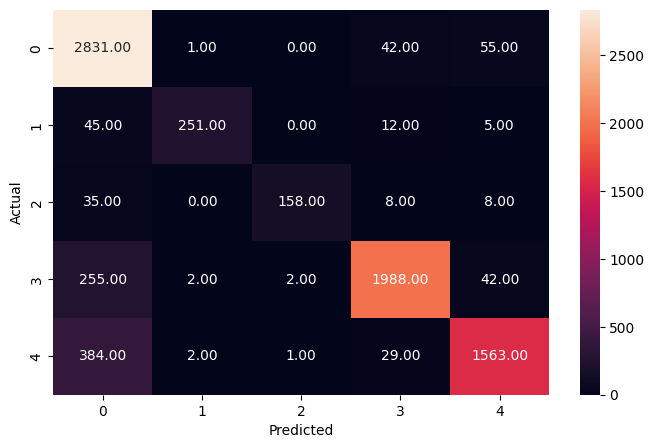

In [622]:
# check performance with training data
pred_loe = model_loe.predict(X_train_loe)
metrics_score(y_train_loe, pred_loe)

We don't have the y_test set here. From the training set, the accuracy seems quite high, and since RandomForests are prone to overfitting, I would say the model is giving valid prediction.

In [623]:
X_predict_loe = df_loe.drop(['LoE_DI', 'YoB', 'gender'], axis=1)
pred_loe = model_loe.predict(X_predict_loe)

# Fill in the predicted values back into the DataFrame
df_loe[column1] = pred_loe

<ipython-input-623-04ae45ef8a67>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loe[column1] = pred_loe


In [624]:
df_loe

,registered,viewed,explored,certified,LoE_DI,YoB,gender,nevents,ndays_act,nplay_video,...,final_cc_cname_DI_Spain,final_cc_cname_DI_Ukraine,final_cc_cname_DI_United Kingdom,final_cc_cname_DI_United States,final_cc_cname_DI_Unknown/Other,course_id_HarvardX/CB22x/2013_Spring,course_id_HarvardX/CS50x/2012,course_id_HarvardX/ER22x/2013_Spring,course_id_HarvardX/PH207x/2012_Fall,course_id_HarvardX/PH278x/2013_Spring
2,1,1,1,1,Secondary,NaN,NaN,77.0,18.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
22,1,0,0,0,Bachelor's,NaN,NaN,3.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
27,1,1,1,1,Secondary,NaN,NaN,252.0,37.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
43,1,0,0,0,Bachelor's,NaN,m,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
46,1,0,0,0,Bachelor's,1982.0,f,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8717,1,1,1,1,Master's,NaN,NaN,300.0,32.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
8724,1,1,1,0,Master's,NaN,NaN,708.0,19.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
8729,1,1,0,0,Secondary,NaN,NaN,11.0,2.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
8740,1,1,0,0,Secondary,NaN,NaN,397.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [625]:
# update the orginal dataset with the predicted values
df_num.update(df_loe)
df_num

,registered,viewed,explored,certified,LoE_DI,YoB,gender,nevents,ndays_act,nplay_video,...,final_cc_cname_DI_Spain,final_cc_cname_DI_Ukraine,final_cc_cname_DI_United Kingdom,final_cc_cname_DI_United States,final_cc_cname_DI_Unknown/Other,course_id_HarvardX/CB22x/2013_Spring,course_id_HarvardX/CS50x/2012,course_id_HarvardX/ER22x/2013_Spring,course_id_HarvardX/PH207x/2012_Fall,course_id_HarvardX/PH278x/2013_Spring
0,1,1,1,1,Master's,1984.0,m,1161.0,50.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1,1,1,1,Master's,1985.0,f,1360.0,10.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1,1,1,1,Secondary,NaN,NaN,77.0,18.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1,1,1,1,Bachelor's,1982.0,m,1425.0,29.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1,1,0,0,Secondary,1989.0,m,6.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8753,1,0,0,0,Bachelor's,1992.0,m,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
8754,1,1,1,1,Master's,1972.0,f,1962.0,16.0,112.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
8755,1,0,0,0,Doctorate,1973.0,m,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
8756,1,1,1,1,Master's,1981.0,m,1110.0,23.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


Since 'LoE_DI' is a categorical column, I will convert it the same way with one-hot encoding.

In [626]:
encoded_loe = encoder.fit_transform(df_num[['LoE_DI']])
encoded_df = pd.DataFrame(encoded_loe, columns=encoder.get_feature_names_out())
df_num = pd.concat([df_num, encoded_df], axis=1)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [627]:
df_num = df_num.drop(column1, axis = 1)

All the same steps with the next column with missing values.

In [628]:
column2 = 'YoB'

In [629]:
df_clean = df_num.dropna()

In [630]:
df_yob = df_num[df_num[column2].isna()]

In [631]:
X_train_yob = df_clean.drop([column2, 'gender'], axis=1)
y_train_yob = df_clean[column2]

In [632]:
model_yob = RandomForestClassifier(random_state=42)
model_yob.fit(X_train_yob, y_train_yob)

RandomForestClassifier(random_state=42)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

      1931.0       1.00      1.00      1.00         1
      1936.0       1.00      0.50      0.67         2
      1937.0       1.00      1.00      1.00         4
      1938.0       1.00      1.00      1.00         2
      1939.0       1.00      0.75      0.86         4
      1940.0       1.00      1.00      1.00         2
      1941.0       1.00      1.00      1.00         2
      1942.0       1.00      0.80      0.89         5
      1943.0       1.00      0.60      0.75         5
      1944.0       1.00      0.67      0.80         6
      1945.0       1.00      0.86      0.92         7
      1946.0       1.00      1.00      1.00        14
      1947.0       0.88      1.00      0.93         7
      1948.0       1.00      1.00      1.00        12
      1949.0       0.44      0.80      0.57         5
      1950.0       1.00      0.87      0.93        15
      1951.0       1.00      0.89      0.94         9
      1952.0       1.00    

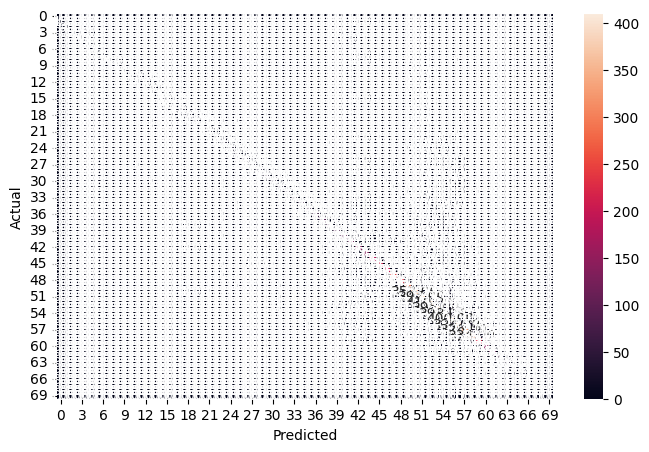

In [633]:
pred_yob = model_yob.predict(X_train_yob)
metrics_score(y_train_yob, pred_yob)

For simplicity, it is predicting years as categorical variables, hence it will predict only years that already exist in the dataset.

In [634]:
X_predict_yob = df_yob.drop([column2, 'gender'], axis=1)
pred_yob = model_yob.predict(X_predict_yob)

df_yob[column2] = pred_yob

<ipython-input-634-2574e8a0743b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_yob[column2] = pred_yob


In [635]:
df_yob

,registered,viewed,explored,certified,YoB,gender,nevents,ndays_act,nplay_video,nchapters,...,course_id_HarvardX/CB22x/2013_Spring,course_id_HarvardX/CS50x/2012,course_id_HarvardX/ER22x/2013_Spring,course_id_HarvardX/PH207x/2012_Fall,course_id_HarvardX/PH278x/2013_Spring,LoE_DI_Bachelor's,LoE_DI_Doctorate,LoE_DI_Less than Secondary,LoE_DI_Master's,LoE_DI_Secondary
2,1,1,1,1,1993.0,NaN,77.0,18.0,0.0,7.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
22,1,0,0,0,1991.0,NaN,3.0,2.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
27,1,1,1,1,1987.0,NaN,252.0,37.0,0.0,11.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
43,1,0,0,0,1986.0,m,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
56,1,1,0,1,1989.0,NaN,621.0,9.0,0.0,9.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8717,1,1,1,1,1988.0,NaN,300.0,32.0,0.0,12.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
8724,1,1,1,0,1958.0,NaN,708.0,19.0,0.0,24.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
8729,1,1,0,0,1992.0,NaN,11.0,2.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
8740,1,1,0,0,1993.0,NaN,397.0,4.0,0.0,7.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [636]:
df_num.update(df_yob)

In [637]:
df_num

,registered,viewed,explored,certified,YoB,gender,nevents,ndays_act,nplay_video,nchapters,...,course_id_HarvardX/CB22x/2013_Spring,course_id_HarvardX/CS50x/2012,course_id_HarvardX/ER22x/2013_Spring,course_id_HarvardX/PH207x/2012_Fall,course_id_HarvardX/PH278x/2013_Spring,LoE_DI_Bachelor's,LoE_DI_Doctorate,LoE_DI_Less than Secondary,LoE_DI_Master's,LoE_DI_Secondary
0,1,1,1,1,1984.0,m,1161.0,50.0,0.0,12.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,1,1,1,1985.0,f,1360.0,10.0,0.0,29.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1,1,1,1,1993.0,NaN,77.0,18.0,0.0,7.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1,1,1,1,1982.0,m,1425.0,29.0,0.0,34.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,1,1,0,0,1989.0,m,6.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8753,1,0,0,0,1992.0,m,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
8754,1,1,1,1,1972.0,f,1962.0,16.0,112.0,13.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
8755,1,0,0,0,1973.0,m,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
8756,1,1,1,1,1981.0,m,1110.0,23.0,0.0,32.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Same with third column.

In [638]:
column3 = 'gender'

In [639]:
df_clean = df_num.dropna()

In [640]:
df_gender = df_num[df_num[column3].isna()]

In [641]:
X_train_gender = df_clean.drop(column3, axis=1)
y_train_gender = df_clean[column3]

In [642]:
model_gender = RandomForestClassifier(random_state=42)
model_gender.fit(X_train_gender, y_train_gender)

RandomForestClassifier(random_state=42)

              precision    recall  f1-score   support

           f       0.98      0.94      0.96      2762
           m       0.97      0.99      0.98      5221

    accuracy                           0.97      7983
   macro avg       0.98      0.97      0.97      7983
weighted avg       0.97      0.97      0.97      7983



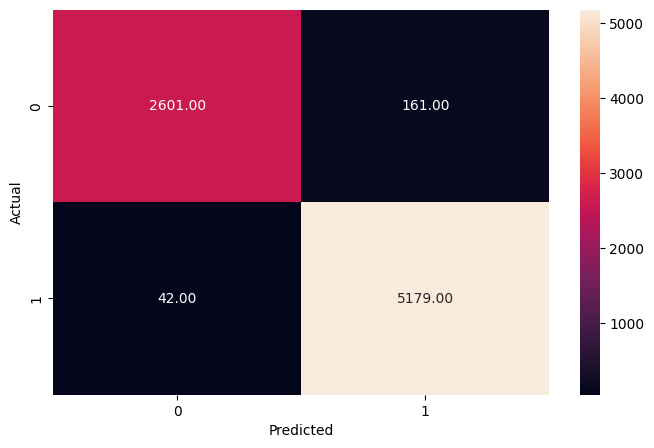

In [643]:
pred_gender = model_gender.predict(X_train_gender)
metrics_score(y_train_gender, pred_gender)

In [644]:
X_predict_gender = df_gender.drop(column3, axis=1)
pred_gender = model_gender.predict(X_predict_gender)

# Fill in the predicted values back into the DataFrame
df_gender[column3] = pred_gender

<ipython-input-644-569b7d30e66c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gender[column3] = pred_gender


In [645]:
df_num.update(df_gender)

In [646]:
df_num

,registered,viewed,explored,certified,YoB,gender,nevents,ndays_act,nplay_video,nchapters,...,course_id_HarvardX/CB22x/2013_Spring,course_id_HarvardX/CS50x/2012,course_id_HarvardX/ER22x/2013_Spring,course_id_HarvardX/PH207x/2012_Fall,course_id_HarvardX/PH278x/2013_Spring,LoE_DI_Bachelor's,LoE_DI_Doctorate,LoE_DI_Less than Secondary,LoE_DI_Master's,LoE_DI_Secondary
0,1,1,1,1,1984.0,m,1161.0,50.0,0.0,12.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,1,1,1,1985.0,f,1360.0,10.0,0.0,29.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1,1,1,1,1993.0,m,77.0,18.0,0.0,7.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1,1,1,1,1982.0,m,1425.0,29.0,0.0,34.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,1,1,0,0,1989.0,m,6.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8753,1,0,0,0,1992.0,m,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
8754,1,1,1,1,1972.0,f,1962.0,16.0,112.0,13.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
8755,1,0,0,0,1973.0,m,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
8756,1,1,1,1,1981.0,m,1110.0,23.0,0.0,32.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [647]:
# check missing values again
np.sum(df_num.isna())

registered                                                  0
viewed                                                      0
explored                                                    0
certified                                                   0
YoB                                                         0
gender                                                      0
nevents                                                     0
ndays_act                                                   0
nplay_video                                                 0
nchapters                                                   0
nforum_posts                                                0
duration_days                                               0
final_cc_cname_DI_Australia                                 0
final_cc_cname_DI_Bangladesh                                0
final_cc_cname_DI_Brazil                                    0
final_cc_cname_DI_Canada                                    0
final_cc

In [648]:
encoded_gender = encoder.fit_transform(df_num[['gender']])
encoded_df = pd.DataFrame(encoded_gender, columns=encoder.get_feature_names_out())

df_num = pd.concat([df_num, encoded_df], axis=1)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [649]:
df_num = df_num.drop('gender', axis = 1)

# Train 1st random forest model with the cleaned training dataset

## Without hyperparameter

In [650]:
target = 'certified'

In [651]:
X_train = df_num.drop(target, axis=1)
y_train = df_num[target]

In [652]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4869
           1       1.00      1.00      1.00      3889

    accuracy                           1.00      8758
   macro avg       1.00      1.00      1.00      8758
weighted avg       1.00      1.00      1.00      8758



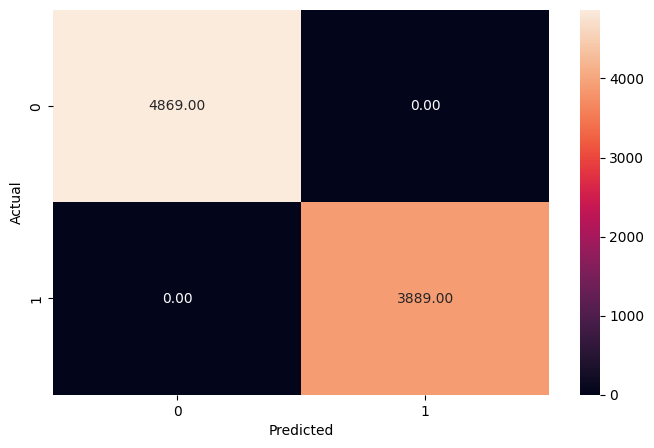

In [653]:
pred_train = model.predict(X_train)
metrics_score(y_train, pred_train)

Right now it is giving 100% accuracy. I don't know how much it is overfitting. I will just have to get the test predictions and upload to Kaggle to check.

### Process test data

I will process the test data with the similar method as how I cleaned the training data.

In [654]:
df_test = pd.read_csv('edx_test.csv').drop(['userid_DI'], axis=1)
df_test

,course_id,registered,viewed,explored,final_cc_cname_DI,LoE_DI,YoB,gender,start_time_DI,last_event_DI,nevents,ndays_act,nplay_video,nchapters,nforum_posts
0,HarvardX/CS50x/2012,1,1,1,United Kingdom,Secondary,1971.0,m,10/30/12,6/27/13,132.0,34.0,NaN,12.0,0
1,HarvardX/CB22x/2013_Spring,1,0,0,Other South Asia,Bachelor's,1984.0,m,2/6/13,11/17/13,NaN,NaN,NaN,NaN,0
2,HarvardX/PH207x/2012_Fall,1,1,1,Egypt,Bachelor's,1985.0,f,10/20/12,1/18/13,2650.0,32.0,96.0,15.0,0
3,HarvardX/PH278x/2013_Spring,1,1,1,Nigeria,Secondary,1988.0,m,12/27/12,8/22/13,999.0,17.0,13.0,8.0,0
4,HarvardX/ER22x/2013_Spring,1,1,1,Other Middle East/Central Asia,NaN,NaN,NaN,5/31/13,9/7/13,2130.0,24.0,NaN,29.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2915,HarvardX/CS50x/2012,1,0,0,Unknown/Other,Bachelor's,1983.0,m,9/14/12,NaN,NaN,NaN,NaN,NaN,0
2916,HarvardX/CS50x/2012,1,1,1,Other South America,Secondary,1987.0,m,7/17/13,7/23/13,177.0,7.0,NaN,12.0,0
2917,HarvardX/PH207x/2012_Fall,1,1,0,Egypt,NaN,1992.0,f,10/7/12,4/29/13,1198.0,9.0,397.0,3.0,0
2918,HarvardX/ER22x/2013_Spring,1,1,0,Other Africa,Bachelor's,1991.0,m,7/29/13,7/29/13,190.0,1.0,NaN,4.0,0


In [655]:
np.sum(df_test.isna())

course_id               0
registered              0
viewed                  0
explored                0
final_cc_cname_DI       0
LoE_DI                351
YoB                   310
gender                260
start_time_DI           0
last_event_DI         559
nevents               601
ndays_act             601
nplay_video          2261
nchapters             908
nforum_posts            0
dtype: int64

In [656]:
df_test[columns_to_update] = df_test[columns_to_update].fillna(0)

In [657]:
# Convert the columns to datetime
df_test['start_time_DI'] = pd.to_datetime(df_test['start_time_DI'], format='%m/%d/%y')
df_test['last_event_DI'] = pd.to_datetime(df_test['last_event_DI'], format='%m/%d/%y', errors='coerce')

# Calculate the duration in days, replacing NaN with 0
df_test['duration_days'] = (df_test['last_event_DI'] - df_test['start_time_DI']).dt.days
df_test['duration_days'].fillna(0, inplace=True)
df_test['duration_days'] = df_test['duration_days'].astype(int)

In [658]:
encoded_features = encoder.fit_transform(df_test[['final_cc_cname_DI', 'course_id']])
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out())

df_test = pd.concat([df_test, encoded_df], axis=1)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [659]:
df_test = df_test.drop(['final_cc_cname_DI', 'start_time_DI', 'last_event_DI', 'course_id'], axis=1)

In [660]:
df_test

,registered,viewed,explored,LoE_DI,YoB,gender,nevents,ndays_act,nplay_video,nchapters,...,final_cc_cname_DI_Spain,final_cc_cname_DI_Ukraine,final_cc_cname_DI_United Kingdom,final_cc_cname_DI_United States,final_cc_cname_DI_Unknown/Other,course_id_HarvardX/CB22x/2013_Spring,course_id_HarvardX/CS50x/2012,course_id_HarvardX/ER22x/2013_Spring,course_id_HarvardX/PH207x/2012_Fall,course_id_HarvardX/PH278x/2013_Spring
0,1,1,1,Secondary,1971.0,m,132.0,34.0,0.0,12.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1,0,0,Bachelor's,1984.0,m,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1,1,1,Bachelor's,1985.0,f,2650.0,32.0,96.0,15.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1,1,1,Secondary,1988.0,m,999.0,17.0,13.0,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1,1,1,NaN,NaN,NaN,2130.0,24.0,0.0,29.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2915,1,0,0,Bachelor's,1983.0,m,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2916,1,1,1,Secondary,1987.0,m,177.0,7.0,0.0,12.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2917,1,1,0,NaN,1992.0,f,1198.0,9.0,397.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2918,1,1,0,Bachelor's,1991.0,m,190.0,1.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [661]:
df_clean = df_test.dropna()

In [662]:
df_loe = df_test[df_test[column1].isna()]

In [663]:
X_train_loe = df_clean.drop(['LoE_DI', 'YoB', 'gender'], axis=1)
y_train_loe = df_clean[column1]

In [664]:
model_loe = RandomForestClassifier(random_state=42)
model_loe.fit(X_train_loe, y_train_loe)

RandomForestClassifier(random_state=42)

                     precision    recall  f1-score   support

         Bachelor's       0.82      0.97      0.89       988
          Doctorate       0.99      0.86      0.92        81
Less than Secondary       0.98      0.80      0.88        79
           Master's       0.94      0.87      0.91       798
          Secondary       0.93      0.80      0.86       603

           accuracy                           0.89      2549
          macro avg       0.93      0.86      0.89      2549
       weighted avg       0.90      0.89      0.89      2549



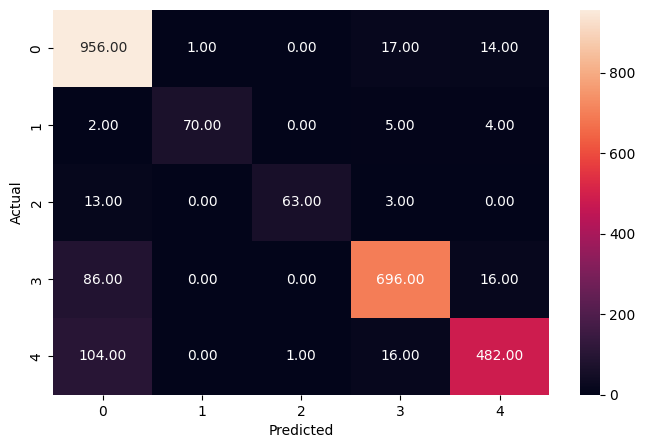

In [665]:
pred_loe = model_loe.predict(X_train_loe)
metrics_score(y_train_loe, pred_loe)

In [666]:
X_predict_loe = df_loe.drop(['LoE_DI', 'YoB', 'gender'], axis=1)
pred_loe = model_loe.predict(X_predict_loe)

df_loe[column1] = pred_loe

<ipython-input-666-33561833318b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loe[column1] = pred_loe


In [667]:
df_test.update(df_loe)
df_test

,registered,viewed,explored,LoE_DI,YoB,gender,nevents,ndays_act,nplay_video,nchapters,...,final_cc_cname_DI_Spain,final_cc_cname_DI_Ukraine,final_cc_cname_DI_United Kingdom,final_cc_cname_DI_United States,final_cc_cname_DI_Unknown/Other,course_id_HarvardX/CB22x/2013_Spring,course_id_HarvardX/CS50x/2012,course_id_HarvardX/ER22x/2013_Spring,course_id_HarvardX/PH207x/2012_Fall,course_id_HarvardX/PH278x/2013_Spring
0,1,1,1,Secondary,1971.0,m,132.0,34.0,0.0,12.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1,0,0,Bachelor's,1984.0,m,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1,1,1,Bachelor's,1985.0,f,2650.0,32.0,96.0,15.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1,1,1,Secondary,1988.0,m,999.0,17.0,13.0,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1,1,1,Bachelor's,NaN,NaN,2130.0,24.0,0.0,29.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2915,1,0,0,Bachelor's,1983.0,m,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2916,1,1,1,Secondary,1987.0,m,177.0,7.0,0.0,12.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2917,1,1,0,Bachelor's,1992.0,f,1198.0,9.0,397.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2918,1,1,0,Bachelor's,1991.0,m,190.0,1.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [668]:
encoded_loe = encoder.fit_transform(df_test[['LoE_DI']])
encoded_df = pd.DataFrame(encoded_loe, columns=encoder.get_feature_names_out())
df_test = pd.concat([df_test, encoded_df], axis=1)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [669]:
df_test = df_test.drop(column1, axis = 1)

In [670]:
df_test

,registered,viewed,explored,YoB,gender,nevents,ndays_act,nplay_video,nchapters,nforum_posts,...,course_id_HarvardX/CB22x/2013_Spring,course_id_HarvardX/CS50x/2012,course_id_HarvardX/ER22x/2013_Spring,course_id_HarvardX/PH207x/2012_Fall,course_id_HarvardX/PH278x/2013_Spring,LoE_DI_Bachelor's,LoE_DI_Doctorate,LoE_DI_Less than Secondary,LoE_DI_Master's,LoE_DI_Secondary
0,1,1,1,1971.0,m,132.0,34.0,0.0,12.0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1,0,0,1984.0,m,0.0,0.0,0.0,0.0,0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1,1,1,1985.0,f,2650.0,32.0,96.0,15.0,0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1,1,1,1988.0,m,999.0,17.0,13.0,8.0,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,1,1,1,NaN,NaN,2130.0,24.0,0.0,29.0,0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2915,1,0,0,1983.0,m,0.0,0.0,0.0,0.0,0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2916,1,1,1,1987.0,m,177.0,7.0,0.0,12.0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2917,1,1,0,1992.0,f,1198.0,9.0,397.0,3.0,0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2918,1,1,0,1991.0,m,190.0,1.0,0.0,4.0,0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [671]:
df_clean = df_test.dropna()

In [672]:
df_yob = df_test[df_test[column2].isna()]

In [673]:
X_train_yob = df_clean.drop([column2, 'gender'], axis=1)
y_train_yob = df_clean[column2]

In [674]:
model_yob = RandomForestClassifier(random_state=42)
model_yob.fit(X_train_yob, y_train_yob)

RandomForestClassifier(random_state=42)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

      1936.0       1.00      1.00      1.00         1
      1937.0       1.00      1.00      1.00         1
      1939.0       1.00      1.00      1.00         2
      1941.0       0.75      1.00      0.86         3
      1942.0       0.00      0.00      0.00         1
      1943.0       1.00      1.00      1.00         2
      1944.0       1.00      0.75      0.86         4
      1945.0       1.00      1.00      1.00         1
      1946.0       1.00      1.00      1.00         2
      1947.0       1.00      1.00      1.00         2
      1948.0       1.00      1.00      1.00         2
      1949.0       1.00      1.00      1.00         6
      1950.0       1.00      1.00      1.00         4
      1951.0       1.00      1.00      1.00         5
      1952.0       1.00      0.67      0.80         6
      1953.0       0.75      0.60      0.67         5
      1954.0       1.00      0.67      0.80         3
      1955.0       1.00    

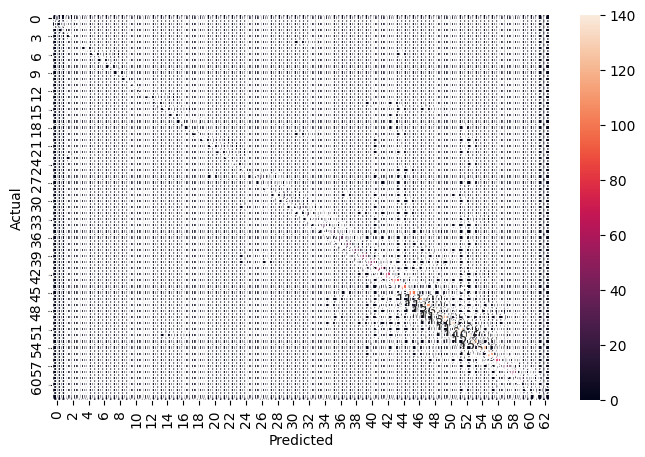

In [675]:
pred_yob = model_yob.predict(X_train_yob)
metrics_score(y_train_yob, pred_yob)

In [676]:
X_predict_yob = df_yob.drop([column2, 'gender'], axis=1)
pred_yob = model_yob.predict(X_predict_yob)

df_yob[column2] = pred_yob

<ipython-input-676-2574e8a0743b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_yob[column2] = pred_yob


In [677]:
df_test.update(df_yob)

In [678]:
df_test

,registered,viewed,explored,YoB,gender,nevents,ndays_act,nplay_video,nchapters,nforum_posts,...,course_id_HarvardX/CB22x/2013_Spring,course_id_HarvardX/CS50x/2012,course_id_HarvardX/ER22x/2013_Spring,course_id_HarvardX/PH207x/2012_Fall,course_id_HarvardX/PH278x/2013_Spring,LoE_DI_Bachelor's,LoE_DI_Doctorate,LoE_DI_Less than Secondary,LoE_DI_Master's,LoE_DI_Secondary
0,1,1,1,1971.0,m,132.0,34.0,0.0,12.0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1,0,0,1984.0,m,0.0,0.0,0.0,0.0,0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1,1,1,1985.0,f,2650.0,32.0,96.0,15.0,0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1,1,1,1988.0,m,999.0,17.0,13.0,8.0,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,1,1,1,1988.0,NaN,2130.0,24.0,0.0,29.0,0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2915,1,0,0,1983.0,m,0.0,0.0,0.0,0.0,0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2916,1,1,1,1987.0,m,177.0,7.0,0.0,12.0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2917,1,1,0,1992.0,f,1198.0,9.0,397.0,3.0,0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2918,1,1,0,1991.0,m,190.0,1.0,0.0,4.0,0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [679]:
df_clean = df_test.dropna()

In [680]:
df_gender = df_test[df_test[column3].isna()]

In [681]:
X_train_gender = df_clean.drop(column3, axis=1)
y_train_gender = df_clean[column3]

In [682]:
model_gender = RandomForestClassifier(random_state=42)
model_gender.fit(X_train_gender, y_train_gender)

RandomForestClassifier(random_state=42)

              precision    recall  f1-score   support

           f       0.98      0.96      0.97       927
           m       0.98      0.99      0.99      1733

    accuracy                           0.98      2660
   macro avg       0.98      0.98      0.98      2660
weighted avg       0.98      0.98      0.98      2660



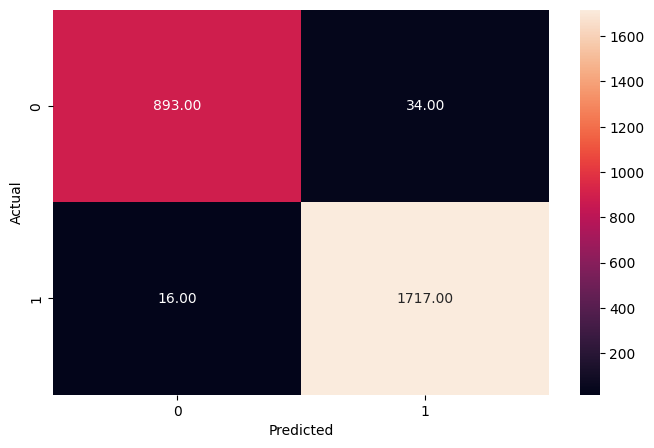

In [683]:
pred_gender = model_gender.predict(X_train_gender)
metrics_score(y_train_gender, pred_gender)

In [684]:
X_predict_gender = df_gender.drop(column3, axis=1)
pred_gender = model_gender.predict(X_predict_gender)

df_gender[column3] = pred_gender

<ipython-input-684-6ce34a55da48>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gender[column3] = pred_gender


In [685]:
df_test.update(df_gender)

In [686]:
df_test

,registered,viewed,explored,YoB,gender,nevents,ndays_act,nplay_video,nchapters,nforum_posts,...,course_id_HarvardX/CB22x/2013_Spring,course_id_HarvardX/CS50x/2012,course_id_HarvardX/ER22x/2013_Spring,course_id_HarvardX/PH207x/2012_Fall,course_id_HarvardX/PH278x/2013_Spring,LoE_DI_Bachelor's,LoE_DI_Doctorate,LoE_DI_Less than Secondary,LoE_DI_Master's,LoE_DI_Secondary
0,1,1,1,1971.0,m,132.0,34.0,0.0,12.0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1,0,0,1984.0,m,0.0,0.0,0.0,0.0,0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1,1,1,1985.0,f,2650.0,32.0,96.0,15.0,0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1,1,1,1988.0,m,999.0,17.0,13.0,8.0,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,1,1,1,1988.0,f,2130.0,24.0,0.0,29.0,0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2915,1,0,0,1983.0,m,0.0,0.0,0.0,0.0,0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2916,1,1,1,1987.0,m,177.0,7.0,0.0,12.0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2917,1,1,0,1992.0,f,1198.0,9.0,397.0,3.0,0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2918,1,1,0,1991.0,m,190.0,1.0,0.0,4.0,0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [687]:
np.sum(df_test.isna())

registered                                                  0
viewed                                                      0
explored                                                    0
YoB                                                         0
gender                                                      0
nevents                                                     0
ndays_act                                                   0
nplay_video                                                 0
nchapters                                                   0
nforum_posts                                                0
duration_days                                               0
final_cc_cname_DI_Australia                                 0
final_cc_cname_DI_Bangladesh                                0
final_cc_cname_DI_Brazil                                    0
final_cc_cname_DI_Canada                                    0
final_cc_cname_DI_China                                     0
final_cc

In [688]:
encoded_gender = encoder.fit_transform(df_test[['gender']])
encoded_df = pd.DataFrame(encoded_gender, columns=encoder.get_feature_names_out())

df_test = pd.concat([df_test, encoded_df], axis=1)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [689]:
df_test = df_test.drop('gender', axis = 1)
df_test

,registered,viewed,explored,YoB,nevents,ndays_act,nplay_video,nchapters,nforum_posts,duration_days,...,course_id_HarvardX/ER22x/2013_Spring,course_id_HarvardX/PH207x/2012_Fall,course_id_HarvardX/PH278x/2013_Spring,LoE_DI_Bachelor's,LoE_DI_Doctorate,LoE_DI_Less than Secondary,LoE_DI_Master's,LoE_DI_Secondary,gender_f,gender_m
0,1,1,1,1971.0,132.0,34.0,0.0,12.0,0,240,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,1,0,0,1984.0,0.0,0.0,0.0,0.0,0,284,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1,1,1,1985.0,2650.0,32.0,96.0,15.0,0,90,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1,1,1,1988.0,999.0,17.0,13.0,8.0,0,238,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,1,1,1,1988.0,2130.0,24.0,0.0,29.0,0,99,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2915,1,0,0,1983.0,0.0,0.0,0.0,0.0,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2916,1,1,1,1987.0,177.0,7.0,0.0,12.0,0,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2917,1,1,0,1992.0,1198.0,9.0,397.0,3.0,0,204,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2918,1,1,0,1991.0,190.0,1.0,0.0,4.0,0,0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


### Get predictions of test data

In [690]:
pred_test = model.predict(df_test)

In [691]:
pred_test

array([1, 0, 1, ..., 0, 0, 0])

In [692]:
to_save = pd.read_csv('edx_test.csv')[['userid_DI']].copy()
to_save.loc[:, 'certified'] = pred_test
to_save.to_csv('submission.csv', index=False)

In [693]:
to_save

,userid_DI,certified
0,MHxPC130476531,1
1,MHxPC130559898,0
2,MHxPC130552712,1
3,MHxPC130394971,1
4,MHxPC130191077,1
...,...,...
2915,MHxPC130421523,0
2916,MHxPC130116114,0
2917,MHxPC130239033,0
2918,MHxPC130445460,0


This output gave 98% accuracy on Kaggle.

Now I will try a different model.

## With hyperparameter

In [694]:
model_hyper = RandomForestClassifier(random_state=42, n_estimators = 300)
model_hyper.fit(X_train, y_train)

RandomForestClassifier(n_estimators=300, random_state=42)

In [695]:
pred_test = model_hyper.predict(df_test)

In [696]:
to_save = pd.read_csv('edx_test.csv')[['userid_DI']].copy()
to_save.loc[:, 'certified'] = pred_test
to_save.to_csv('submission4.csv', index=False)

This actually did no improve the model's performance in Kaggle.

# Train 2nd neural network model

## Without validation

Since neural network is different from random forest, we need to scale the X dataset before continuing.

In [697]:
input_dim = X_train.shape[1]

In [698]:
model_nn = Sequential([
    Dense(64, input_shape=(input_dim,), activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [699]:
model_nn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [700]:
model_nn.fit(X_train, y_train,
                    epochs=50,
                    batch_size=32)

Epoch 1/50
274/274 [==============================] - 2s 2ms/step - loss: 1.3585 - accuracy: 0.9140
Epoch 2/50
274/274 [==============================] - 1s 2ms/step - loss: 0.6061 - accuracy: 0.9202
Epoch 3/50
274/274 [==============================] - 1s 3ms/step - loss: 0.5152 - accuracy: 0.9268
Epoch 4/50
274/274 [==============================] - 1s 2ms/step - loss: 0.7219 - accuracy: 0.9240
Epoch 5/50
274/274 [==============================] - 1s 2ms/step - loss: 0.4744 - accuracy: 0.9342
Epoch 6/50
274/274 [==============================] - 1s 2ms/step - loss: 0.5058 - accuracy: 0.9334
Epoch 7/50
274/274 [==============================] - 1s 3ms/step - loss: 0.4491 - accuracy: 0.9374
Epoch 8/50
274/274 [==============================] - 1s 2ms/step - loss: 0.4304 - accuracy: 0.9363
Epoch 9/50
274/274 [==============================] - 1s 2ms/step - loss: 0.5242 - accuracy: 0.9318
Epoch 10/50
274/274 [==============================] - 1s 2ms/step - loss: 0.4487 - accuracy: 0.9388

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4869
           1       1.00      1.00      1.00      3889

    accuracy                           1.00      8758
   macro avg       1.00      1.00      1.00      8758
weighted avg       1.00      1.00      1.00      8758



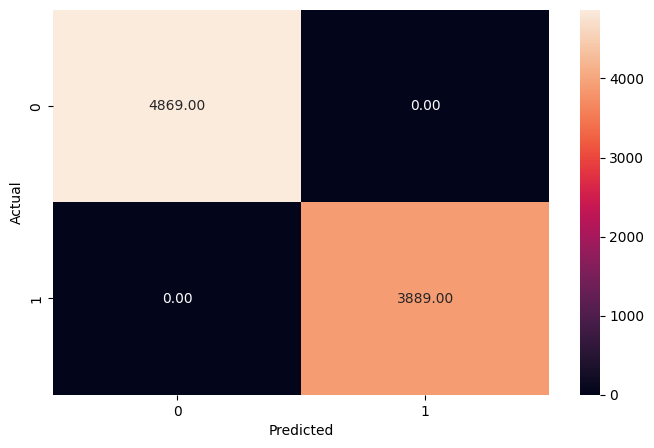

In [701]:
nn_pred_train = model.predict(X_train)
metrics_score(y_train, nn_pred_train)

This model also gives 100% accuracy on training set. Since neural network models will overfit very easily, I might try using validation sets if the accuracy with the test data is low.

In [702]:
pred_test_nn = model_nn.predict(df_test)

92/92 [==============================] - 0s 2ms/step


In [703]:
pred_test_nn = (pred_test_nn > 0.5).astype(int)

In [704]:
nn = pd.read_csv('edx_test.csv')[['userid_DI']].copy()
nn.loc[:, 'certified'] = pred_test_nn
nn.to_csv('submission2.csv', index=False)

The accuracy I got was around 96%, lower than what I got for the random forest model. I will try to use validation set to see if it improves the performance.

## With validation

Since this will change the training dataset, make sure it is ran at the last.

In [705]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [706]:
model_nn.fit(X_train, y_train,
                    epochs=50,
                    batch_size=32,
            validation_data=(X_val, y_val))

Epoch 1/50
219/219 [==============================] - 1s 4ms/step - loss: 0.1120 - accuracy: 0.9659 - val_loss: 0.1105 - val_accuracy: 0.9692
Epoch 2/50
219/219 [==============================] - 1s 3ms/step - loss: 0.1182 - accuracy: 0.9636 - val_loss: 0.1354 - val_accuracy: 0.9652
Epoch 3/50
219/219 [==============================] - 1s 3ms/step - loss: 0.1095 - accuracy: 0.9657 - val_loss: 0.1448 - val_accuracy: 0.9395
Epoch 4/50
219/219 [==============================] - 1s 5ms/step - loss: 0.1189 - accuracy: 0.9646 - val_loss: 0.1234 - val_accuracy: 0.9686
Epoch 5/50
219/219 [==============================] - 1s 5ms/step - loss: 0.1164 - accuracy: 0.9642 - val_loss: 0.1454 - val_accuracy: 0.9578
Epoch 6/50
219/219 [==============================] - 1s 6ms/step - loss: 0.1332 - accuracy: 0.9605 - val_loss: 0.1672 - val_accuracy: 0.9612
Epoch 7/50
219/219 [==============================] - 1s 3ms/step - loss: 0.1203 - accuracy: 0.9636 - val_loss: 0.1020 - val_accuracy: 0.9669
Epoch 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3892
           1       1.00      1.00      1.00      3114

    accuracy                           1.00      7006
   macro avg       1.00      1.00      1.00      7006
weighted avg       1.00      1.00      1.00      7006



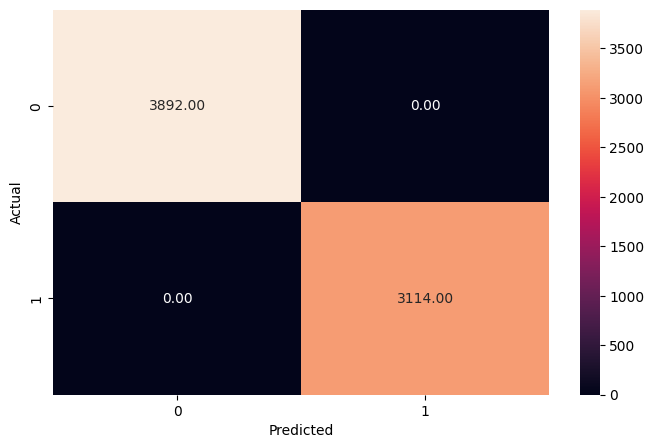

In [707]:
nn_pred_train = model.predict(X_train)
metrics_score(y_train, nn_pred_train)

In [708]:
pred_test_nn = model_nn.predict(df_test)

92/92 [==============================] - 0s 2ms/step


In [709]:
pred_test_nn = (pred_test_nn > 0.5).astype(int)

In [710]:
nn = pd.read_csv('edx_test.csv')[['userid_DI']].copy()
nn.loc[:, 'certified'] = pred_test_nn
nn.to_csv('submission3.csv', index=False)

This did increases accuracy to about 97% on Kaggle. I think I will end here.

# **Discussion**

## **[7 Pts] Training the Models**

**Instructions**: Discuss what models you tried, and what you did to improve your initial predictions. Discuss what hyperparameters you tried, and which hyperparameters seemed important for your final model. Finally, discuss what you are inferring from the above visualiation(s)

From the start, I remembered that the random forest model usually has good performance, and is prone to overfitting. So I went to a random forest as my first choice of model. To ensure the model learns well, I handled the missing values carefully by using different random forest models to predict the rows with missing data. And the initial predictions with the cleaned data using random forest model was quite well.

I tried using a different number of estimators, to see if increasing the number of estimators would even further improve the model's performance. We learned in class that generally the more trees you grow, the better the random forest predicts. However, I got the same accuracy from Kaggle using this new model. So I concluded that the model is already learning well, and small changes in the hyperparameters won't make too much change.

Then I decided to try neural networks model. I know that they tend to have very good performance, but quite likely to overfit. I wanted to try training a model without any validation set to see how the model initially performs and whether it overfits. To my surprise, it is not overfitting a lot, but doesn't have as good of a performance as the random forest model. Then I added the validation set, split from the training dataset, to see if it could reduce overfit. From the accuracy given by Kaggle, I can see that it did actually improve the accuracy, but just slightly, and still not as good as random forest.

I did many confusian matrix visualizations, to help me understand the models' performances on train data, as well as when I was predicting values for the missing data. All the training data gave 100% accuracy. I was initially worried about overfitting, but turns out it was okay.

## **[3 Pts] Feature Selection**

**Instructions**: Discuss what features you used and whether you did some transformations on them. What features seemed important for your final model?

Initially, I wanted to include all the features and look at the performance before going to any feature selection. As I proceeded, all the models performed quite well without having to reduce any features. Especially for random forest, I think each individual tree does some feature selection, so I think it is not as important to do feature selection for random forest. Hence, I kept all the features for all the models. I did try to remove courseID, as I thought it wouldn't help with prediction. But it actually decreased accuracy in the phase of missing data predictions.

I had to do a lot of missing data handeling, and coverting categorical values to one-hot encoding. So I ended up with about 56 predictors. If I had more time, I would probably had looked at how reducing different combinations of predictors would affect the model's predictions.

In the end, all features seem important for the final models.

## **[5 Pts] Ethical Implications**

**Instructions**: Consider and discuss the ethical implications of using the model you trained. Imagine you were hired to work as a data scientist for an online education platform (exciting, right?). They want to use your model to predict which students they should tailor their course material towards so they can maximize their profits. Their idea is to use the model to help predict which student groups (i.e. from specific countries or certain educational backgrounds) would make them the most money by getting the most participants to complete their paid certificate program. Are there any ethical considerations we should think about before acting on that plan?

The main worry is that this approach might leave some students behind. If the model only targets students it sees as profitable, others might not get the same quality of education or attention. This could make it harder for those students to succeed, especially if they're from backgrounds that the model deems less lucrative.

There’s also the need for openness about how these decisions are made. Students and teachers should know how the model works and how it affects the content they see or teach. Everyone needs to trust that the system is working fairly.

Then there's the issue of bias. If the data used to train the model has any historical biases—say, certain groups have had less access to education because of economic or technological reasons—those biases could get baked into the model. This means the platform might unintentionally favor some students over others, not because of their potential, but because of past inequalities.

Before going ahead with this plan, it might be a good idea to bring different voices into the conversation, like ethicists, educators, and students themselves. It’s worth looking at whether focusing on profits is worth the potential downside, especially when it comes to education. Maybe there are better ways to use the model that help more students and still keep the business healthy.